# Variational Autoencoder

In [1]:
from IPython.display import Image, display, clear_output
import os
import torch
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import warnings
import time
import sklearn

from typing import *
from collections import defaultdict
from warnings import simplefilter

from torch import nn, Tensor
from torch.nn.functional import softplus
from torch.distributions import Distribution
from torch.distributions.bernoulli import Bernoulli
from torch.distributions.binomial import Binomial
from torch.distributions.log_normal import LogNormal
from torch.utils.data import random_split, DataLoader, Subset

### Function for plotting during training

In [2]:
def plotting(training_data, validation_data, x, x_hat, tmp_img="tmp_vae_out.png"):
    
    # Creates a 4 by 3 mosaic of subplots
    fig, axes = plt.subplot_mosaic([['top_left', 'top_centre', 'top_right'],
                                    ['mid1', 'mid1', 'mid1'],
                                    ['mid2', 'mid2', 'mid2'],
                                    ['bottom_left', 'bottom_centre', 'bottom_right']])
    
    fig.set_size_inches(20, 15)
    
    # plot ELBO
    axes['top_left'].set_title(r'ELBO: $\mathcal{L} ( \mathbf{x} )$')
    axes['top_left'].plot(training_data['elbo'], label='Training')
    axes['top_left'].plot(validation_data['elbo'], label='Validation')
    axes['top_left'].legend()
    
    # plot KL
    axes['top_centre'].set_title(r'$\mathcal{D}_{\operatorname{KL}}\left(q_\phi(\mathbf{z}|\mathbf{x})\ |\ p(\mathbf{z})\right)$')
    axes['top_centre'].plot(training_data['kl'], label='Training')
    axes['top_centre'].plot(validation_data['kl'], label='Validation')
    axes['top_centre'].legend()
    
    # plot NLL
    axes['top_right'].set_title(r'$\log p_\theta(\mathbf{x} | \mathbf{z})$')
    axes['top_right'].plot(training_data['log_px'], label='Training')
    axes['top_right'].plot(validation_data['log_px'], label='Validation')
    axes['top_right'].legend()
    
    # plot sample
    axes['mid1'].set_title(r'Observation $\mathbf{x}$')
    a = axes['mid1'].imshow(x, cmap="plasma", aspect="auto")
    plt.colorbar(a, ax = axes['mid1'], location='right')
    
    # plot reconstruction
    n_data = np.prod(x_hat.shape)
    percent_less_than_zero = round((len(x_hat[x_hat < 0.]) / n_data)*100, 5)
    percent_above_max = round((len(x_hat[x_hat > 10.398675]) / n_data), 5)
    axes['mid2'].set_title(r'Reconstruction $\mathbf{\hat x \sim p(x|z)}$, ' + f'observations below zero: {percent_less_than_zero}%, observations above 10.398675: {percent_above_max}%')
    b = axes['mid2'].imshow(x_hat, cmap="plasma", aspect="auto", vmin=x.min(), vmax=x.max())
    plt.colorbar(b, ax = axes['mid2'], location='right')
    
    # Plot learned mean mu
    axes['bottom_left'].set_title(r'Mean of $\mu$ for observation model')
    axes['bottom_left'].plot(validation_data['mu'])
    axes['bottom_left'].axhline(y=6.0310, c="green", linestyle='dashed')
    axes['bottom_left'].set_ylim(0, 7)
    
    # Plot learned mean sigma
    axes['bottom_centre'].set_title(r'Mean of $\sigma$ for observation model')
    axes['bottom_centre'].plot(validation_data['sigma'])
    axes['bottom_centre'].axhline(y=0.6901, c="green", linestyle='dashed')
    axes['bottom_centre'].set_ylim(0,10)
    
    # Plot learned mean Bernoulli p
    axes['bottom_right'].set_title(r'Mean of Bernoulli $p$ for observation model')
    axes['bottom_right'].plot(validation_data['probs'])
    axes['bottom_right'].axhline(y=0.584, c="green", linestyle='dashed')
    axes['bottom_right'].set_ylim(0.3, 0.8)
    
    plt.tight_layout()
    plt.savefig(tmp_img)
    plt.close(fig)
    display(Image(filename=tmp_img))
    clear_output(wait=True)
    
    os.remove(tmp_img)

## Dataloader function

In [3]:
def data_loaders(DATA_PATH=os.getcwd() + "/Data/archs4_data_transformed.npy", batch_size=32, num_workers=4, pin_memory=True):
    print("LOADING DATA ...")
    start = time.time()
    data = np.load(DATA_PATH)
    end = time.time()
    print(f"Loaded 20% data from parquet in {end-start} seconds")
    print(f"Data size in MB: {round(data.nbytes / 2**20, 3)}")
    
    assert np.isnan(np.sum(data)) == False
    
    print(f"Minimum value in data: {data.min()}")
    print(f"Maximum value in data: {data.max()}")
    nrows = data.shape[0]
    ncols = data.shape[1]
    print("Dataframe dimensions:\n" + str(nrows), "rows *", ncols, "columns")
    print("Data type:", data.dtype)
    
    inputs = torch.from_numpy(data)
    
    inputs_train, inputs_test = random_split(inputs, [0.8,0.2])
    
    # Training data:
    train_loader = DataLoader(dataset = inputs_train,
                              batch_size = batch_size,
                              shuffle = True,
                              num_workers=num_workers, 
                              pin_memory=pin_memory)
    print(f"Number of training samples: {len(train_loader.dataset)}")
    
    # Testing data:
    test_loader = DataLoader(dataset = inputs_test,
                             batch_size = batch_size,
                             shuffle = True,
                             num_workers=num_workers, 
                             pin_memory=pin_memory)
    print(f"Number of test samples: {len(test_loader.dataset)}")
    
    return train_loader, test_loader



## Custom distributions

#### After log2(x+1) and quantile transformation, our data follows a hurdle normal distribution which is implemented below:

In [4]:
class HurdleNormal(Distribution):
    """
    A hurdle model of the Bernoulli and normal distributions to model data which is normally distributed with an excess probability mass at 0
    Hurdle Normal PDF:
    p(x | mu, sigma, p) = p for x=0
    p(x | mu, sigma, p) = (1-p) * normal distribution pdf
    This is to be used as observation model p(x|z): p(x | z, mu, sigma, p)
    """
    def __init__(self, mu:Tensor, log_sigma:Tensor, p_logits:Tensor):
        assert mu.shape == log_sigma.shape == p_logits.shape, f"Tensors 'mu': {mu.shape}, 'log_sigma': {log_sigma.shape} and 'p': {p_logits.shape} must be of the same shape."
        self.mu = mu
        self.sigma = log_sigma.exp() + 0.01 # to avoid sigma being zero
        self.p_logits = p_logits

        self.Bernoulli = torch.distributions.bernoulli.Bernoulli(logits = self.p_logits)
        
        odds = p_logits.exp()
        prob = odds / (1+odds)
        self.prob = prob
        
    def sample(self) -> Tensor:
        """sample `x ~ hurdle_normal(x | mu, sigma, p)`"""
        
        with torch.no_grad():
            # Bernoulli returns either 0 or 1, and for 1 we want the value from the sampled log_normal distribution so we just multiply them
            B = self.Bernoulli.sample() 
            norm = torch.distributions.normal.Normal(self.mu, self.sigma).sample()
            return B*norm
            
    def log_prob(self, x:Tensor) -> Tensor:
        """
        return log probability: log p(x)
        for x=0:
            p(x|mu, sigma, p) = p 
        for x > 0
            p(x|mu, sigma, p) = (1-p) * 1 / (sigma * sqrt(2*pi)) * exp(-0.5 * ((x - mu) / sigma)) 
        """
        
        idx = x > 0.
        
        # Log prob of zero values = log p
        # Using torch.zeros as for the places where x is not 0 we want (1-p)
        bernoulli_tensor = torch.zeros_like(x)
        bernoulli_tensor[idx] = 1.
        
        log_prob_bernoulli = self.Bernoulli.log_prob(bernoulli_tensor)
        
        log_prob_normal = torch.distributions.normal.Normal(loc = self.mu[idx], scale = self.sigma[idx]).log_prob(x[idx])
        log_prob_normal = torch.zeros_like(log_prob_bernoulli).masked_scatter(idx, log_prob_normal)
        
        # FINAL LOG PROB
        log_p = log_prob_bernoulli + log_prob_normal # Log prob will be log(p) when x=0 and log(p-1) + logprob_normal when x>0

        return log_p

#### The reparameterization trick to be able to backpropagate despite random sampling is used as implemented in the course exercise

In [5]:
class ReparameterizedDiagonalGaussian(Distribution):
    """
    A distribution `N(y | mu, sigma I)` compatible with the reparameterization trick given `epsilon ~ N(0, 1)`.
    """
    def __init__(self, mu: Tensor, log_sigma:Tensor):
        assert mu.shape == log_sigma.shape, f"Tensors `mu` : {mu.shape} and ` log_sigma` : {log_sigma.shape} must be of the same shape"
        self.mu = mu
        self.sigma = log_sigma.exp() + 0.001
        
    def sample_epsilon(self) -> Tensor:
        """`\eps ~ N(0, I)`"""
        return torch.empty_like(self.mu).normal_()
        
    def sample(self) -> Tensor:
        """sample `z ~ N(z | mu, sigma)` (without gradients)"""
        with torch.no_grad():
            return self.rsample()
        
    def rsample(self) -> Tensor:
        """sample `z ~ N(z | mu, sigma)` (with the reparameterization trick) """
        return self.mu + self.sigma * self.sample_epsilon() 
        
    def log_prob(self, z:Tensor) -> Tensor:
        """return the log probability: log `p(z)`"""
        return torch.distributions.normal.Normal(self.mu, self.sigma).log_prob(z)

    def __repr__(self):
        return f"ReparameterizedDiagonalGaussian(mu={self.mu.shape}, sigma={self.sigma.shape})"

## Defining the Variational Autoencoder network
##### Based on the original code from the course exercise, but modified to be able to control number of layers, dimensions of layers and use the hurdle-normal distribution as observation model.

In [6]:
class VariationalAutoencoder(nn.Module):
    """A Variational Autoencoder with
    * a Bernoulli observation model `p_\theta(x | z) = B(x | g_\theta(z))`
    * a Gaussian prior `p(z) = N(z | 0, I)`
    * a Gaussian posterior `q_\phi(z|x) = N(z | \mu(x), \sigma(x))`
    """
    
    def __init__(self, input_shape:torch.Size, latent_features:int, encoder_layer_sizes:list, decoder_layer_sizes:list) -> None:
        super(VariationalAutoencoder, self).__init__()
        
        # ------------------------------------------------------------------------------
        # Defining parameters of model
        self.input_shape = input_shape
        self.latent_features = latent_features
        self.observation_features = np.prod(input_shape)
        
        self.encoder_layer_sizes = encoder_layer_sizes
        self.n_encoder_layers = len(encoder_layer_sizes)
        
        self.decoder_layer_sizes = decoder_layer_sizes
        self.n_decoder_layers = len(decoder_layer_sizes)
        
        # ------------------------------------------------------------------------------
        # Defining flexible encoder
        encoder_layers = [nn.Linear(self.observation_features, self.encoder_layer_sizes[0]), nn.BatchNorm1d(self.encoder_layer_sizes[0])] # input layer
        encoder_layers.append(nn.LeakyReLU()) # Make it non-linear
        for i in range(self.n_encoder_layers-1):
            encoder_layers.append(nn.Linear(self.encoder_layer_sizes[i], self.encoder_layer_sizes[i+1]))
            encoder_layers.append(nn.BatchNorm1d(self.encoder_layer_sizes[i+1]))
            encoder_layers.append(nn.LeakyReLU())
        encoder_layers.append(nn.Linear(self.encoder_layer_sizes[-1], self.latent_features*2)) # output layer
        
        # Inference Network
        # Encode the observation `x` into the parameters of the posterior distribution
        # `q_\phi(z|x) = N(z | \mu(x), \sigma(x)), \mu(x),\log\sigma(x) = h_\phi(x)`
        self.encoder = nn.Sequential(*encoder_layers)
        
        
        # ------------------------------------------------------------------------------
        # Defining flexible decoder
        decoder_layers = [nn.Linear(self.latent_features, self.decoder_layer_sizes[-1]), nn.BatchNorm1d(self.decoder_layer_sizes[-1])] # input layer
        decoder_layers.append(nn.LeakyReLU())
        for i in range(self.n_decoder_layers-1, 0, -1):
            decoder_layers.append(nn.Linear(self.decoder_layer_sizes[i], self.decoder_layer_sizes[i-1]))
            decoder_layers.append(nn.BatchNorm1d(self.decoder_layer_sizes[i-1]))
            decoder_layers.append(nn.LeakyReLU())
        decoder_layers.append(nn.Linear(self.decoder_layer_sizes[0], self.observation_features*3)) # output layer
        
        # Generative Model
        # Decode the latent sample `z` into the parameters of the observation model
        # `p_\theta(x | z) = \prod_i B(x_i | g_\theta(x))`
        self.decoder = nn.Sequential(*decoder_layers)

          
        # ------------------------------------------------------------------------------
        # define the parameters of the prior, chosen as p(z) = N(0, I)
        self.register_buffer('prior_params', torch.zeros(torch.Size([1, 2*latent_features]))) # defines a model state variable, which is not learnable
        
    # ------------------------------------------------------------------------------
    # Distributions
    # ------------------------------------------------------------------------------
    def posterior(self, x:Tensor) -> Distribution:
        """return the distribution `q(z|x) = N(z | \mu(x), \sigma(x))`"""
        h_x = self.encoder(x) # compute the parameters of the posterior
        mu, log_sigma =  h_x.chunk(2, dim=-1) # splits h_x (which contains both both mean and std values) into 2 chunks along dim=-1
        
        # return a distribution `q(x|x) = N(z | \mu(x), \sigma(x))`
        return ReparameterizedDiagonalGaussian(mu, log_sigma)
    
    def prior(self, batch_size:int=1)-> Distribution:
        """return the distribution `p(z)`"""
        prior_params = self.prior_params.expand(batch_size, *self.prior_params.shape[-1:]) # The * unpacks the tuple that .shape returns so that we return each element in the tuple instead (opposite of zip operation)
        mu, log_sigma = prior_params.chunk(2, dim=-1)
        
        return ReparameterizedDiagonalGaussian(mu, log_sigma)
    
    def observation_model(self, z:Tensor) -> Distribution:
        """return the distribution `p(x|z)`"""
        px_params = self.decoder(z)
        px_mu, log_px_sigma, px_logit = px_params.chunk(3, dim=-1)
        
        return HurdleNormal(px_mu, log_px_sigma, px_logit)
        
    # ------------------------------------------------------------------------------
    def forward(self, x) -> Dict[str, Any]:
        """compute the posterior q(z|x) (encoder), sample z~q(z|x) and return the distribution p(x|z) (decoder)"""
        
        # define the posterior q(z|x) / encode x into q(z|x)
        qz = self.posterior(x)
        
        # define the prior p(z)
        pz = self.prior(batch_size=x.size(0))
        
        # sample the posterior using the reparameterization trick: z ~ q(z | x)
        z = qz.rsample()
        
        # define the observation model p(x|z) = B(x | g(z))
        px = self.observation_model(z)
        
        return {'px': px, 'pz': pz, 'qz': qz, 'z': z}
    
    
    def sample_from_prior(self, batch_size:int=100):
        """sample z~p(z) and return p(x|z)"""
        
        # define the prior p(z)
        pz = self.prior(batch_size=batch_size)
        
        # sample the prior 
        z = pz.rsample()
        
        # define the observation model p(x|z) = B(x | g(z))
        px = self.observation_model(z)
        
        return {'px': px, 'pz': pz, 'z': z}

## Variational inference
##### Code unchanged from course exercise

In [7]:
def reduce(x:Tensor) -> Tensor:
    """for each datapoint: sum over all dimensions"""
    return x.view(x.size(0), -1).sum(dim=1)

class VariationalInference(nn.Module):
    def __init__(self, beta:float=1.):
        super().__init__()
        self.beta = beta
        
    def forward(self, model:nn.Module, x:Tensor) -> Tuple[Tensor, Dict]:
        
        # forward pass through the model
        outputs = model(x)

        # unpack outputs
        px, pz, qz, z = [outputs[k] for k in ["px", "pz", "qz", "z"]]
        
        # evaluate log probabilities
        log_px = reduce(px.log_prob(x)) # Probability of seeing input data "x" under hurdle normal distribution "px"
        log_pz = reduce(pz.log_prob(z)) # Prior distribution
        log_qz = reduce(qz.log_prob(z)) # Posterior distribution

        # compute the ELBO with and without the beta parameter: 
        # `L^\beta = E_q [ log p(x|z) ] - \beta * D_KL(q(z|x) | p(z))`
        # where `D_KL(q(z|x) | p(z)) = log q(z|x) - log p(z)`
        kl = log_qz - log_pz

        elbo = torch.mean(log_px) - kl
        beta_elbo = torch.mean(log_px) - self.beta * kl

        # loss
        loss = -beta_elbo.mean()
        
        
        # prepare the output
        with torch.no_grad():
            diagnostics = {'elbo': elbo, 'log_px': log_px, 'kl': kl, 'mu': torch.mean(px.mu, dim=1), 'sigma': torch.mean(px.sigma, dim=1), 'probs': torch.mean(px.prob, dim=1)}
            
        return loss, diagnostics, outputs
        

## Train and test as functions
##### This is in order to be able to use Ray Tune to search for optimal parameters

In [8]:
# ignore all future warnings
simplefilter(action='ignore')
    
def train_and_test(config):
    # Initialize epochs
    num_epochs = 100
    epoch = 0

    # Only used to get cosine similarities between x and x_hat
    cos = torch.nn.CosineSimilarity()
    cosines = []
    
    # Load train and test sets
    train_loader, test_loader = data_loaders(batch_size=config['batch_size'], 
                                             num_workers=4, 
                                             pin_memory=True)
    # Only used to get shape of data
    data_train = next(iter(train_loader))
    
    
    # Initialize model
    vae = VariationalAutoencoder(data_train[0].shape,
                                 config['latent_features'], 
                                 config['encoder_layer_sizes'], 
                                 config['decoder_layer_sizes'])
    
    # Check if GPU is available, else use CPU
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f">> Using device: {device}")
    
    # Transfer model to device
    vae = vae.to(device)
    
    # Evaluator: Variational Inference
    beta = 1
    vi = VariationalInference(beta=beta)
    
    # Optimizer
    optimizer = torch.optim.AdamW(vae.parameters(), 
                                 lr = config['lr'],
                                 weight_decay = config['weight_decay'])
    
    # define dictionary to store the training curves
    training_data = defaultdict(list)
    validation_data = defaultdict(list)
    
    print(f"Training with {num_epochs} epochs starting!")
    
    while epoch < num_epochs:
        epoch+= 1
        training_epoch_data = defaultdict(list)
        vae.train()

        # Go through each batch in the training dataset using the loader
        for x in train_loader:

            x = x.to(device)

            # perform a forward pass through the model and compute the ELBO
            loss, diagnostics, outputs = vi(vae, x)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # gather data for the current bach
            for k, v in diagnostics.items():
                training_epoch_data[k] += [v.mean().item()]

        # gather data for the full epoch
        for k, v in training_epoch_data.items():
            training_data[k] += [np.mean(training_epoch_data[k])]

        # Evaluate on a single batch, do not propagate gradients
        with torch.no_grad():
            vae.eval()

            # Just load a single batch from the test loader
            x = next(iter(test_loader))
            x = x.to(device)

            # perform a forward pass through the model and compute the ELBO
            loss, diagnostics, outputs = vi(vae, x)
            
            # For plotting
            x_hat = outputs['px'].sample()
            x_plot = x.cpu()
            x_hat_plot = x_hat.cpu()
            
            # gather data for the validation step
            for k, v in diagnostics.items():
                validation_data[k] += [v.mean().item()]

            # Save cosine similarities for test batch x vs x_hat
            cosines.append(cos(x_plot, x_hat_plot).mean())
        
        # Plot the training curves
        plotting(training_data, validation_data, x_plot, x_hat_plot)

    # Save final model
    torch.save(vae.state_dict(), os.getcwd()+"/VAE_LARGE_ENCODER_FULL_DATA.pth")

    return x_plot, x_hat_plot, cosines, training_data, validation_data
        

#### Run training

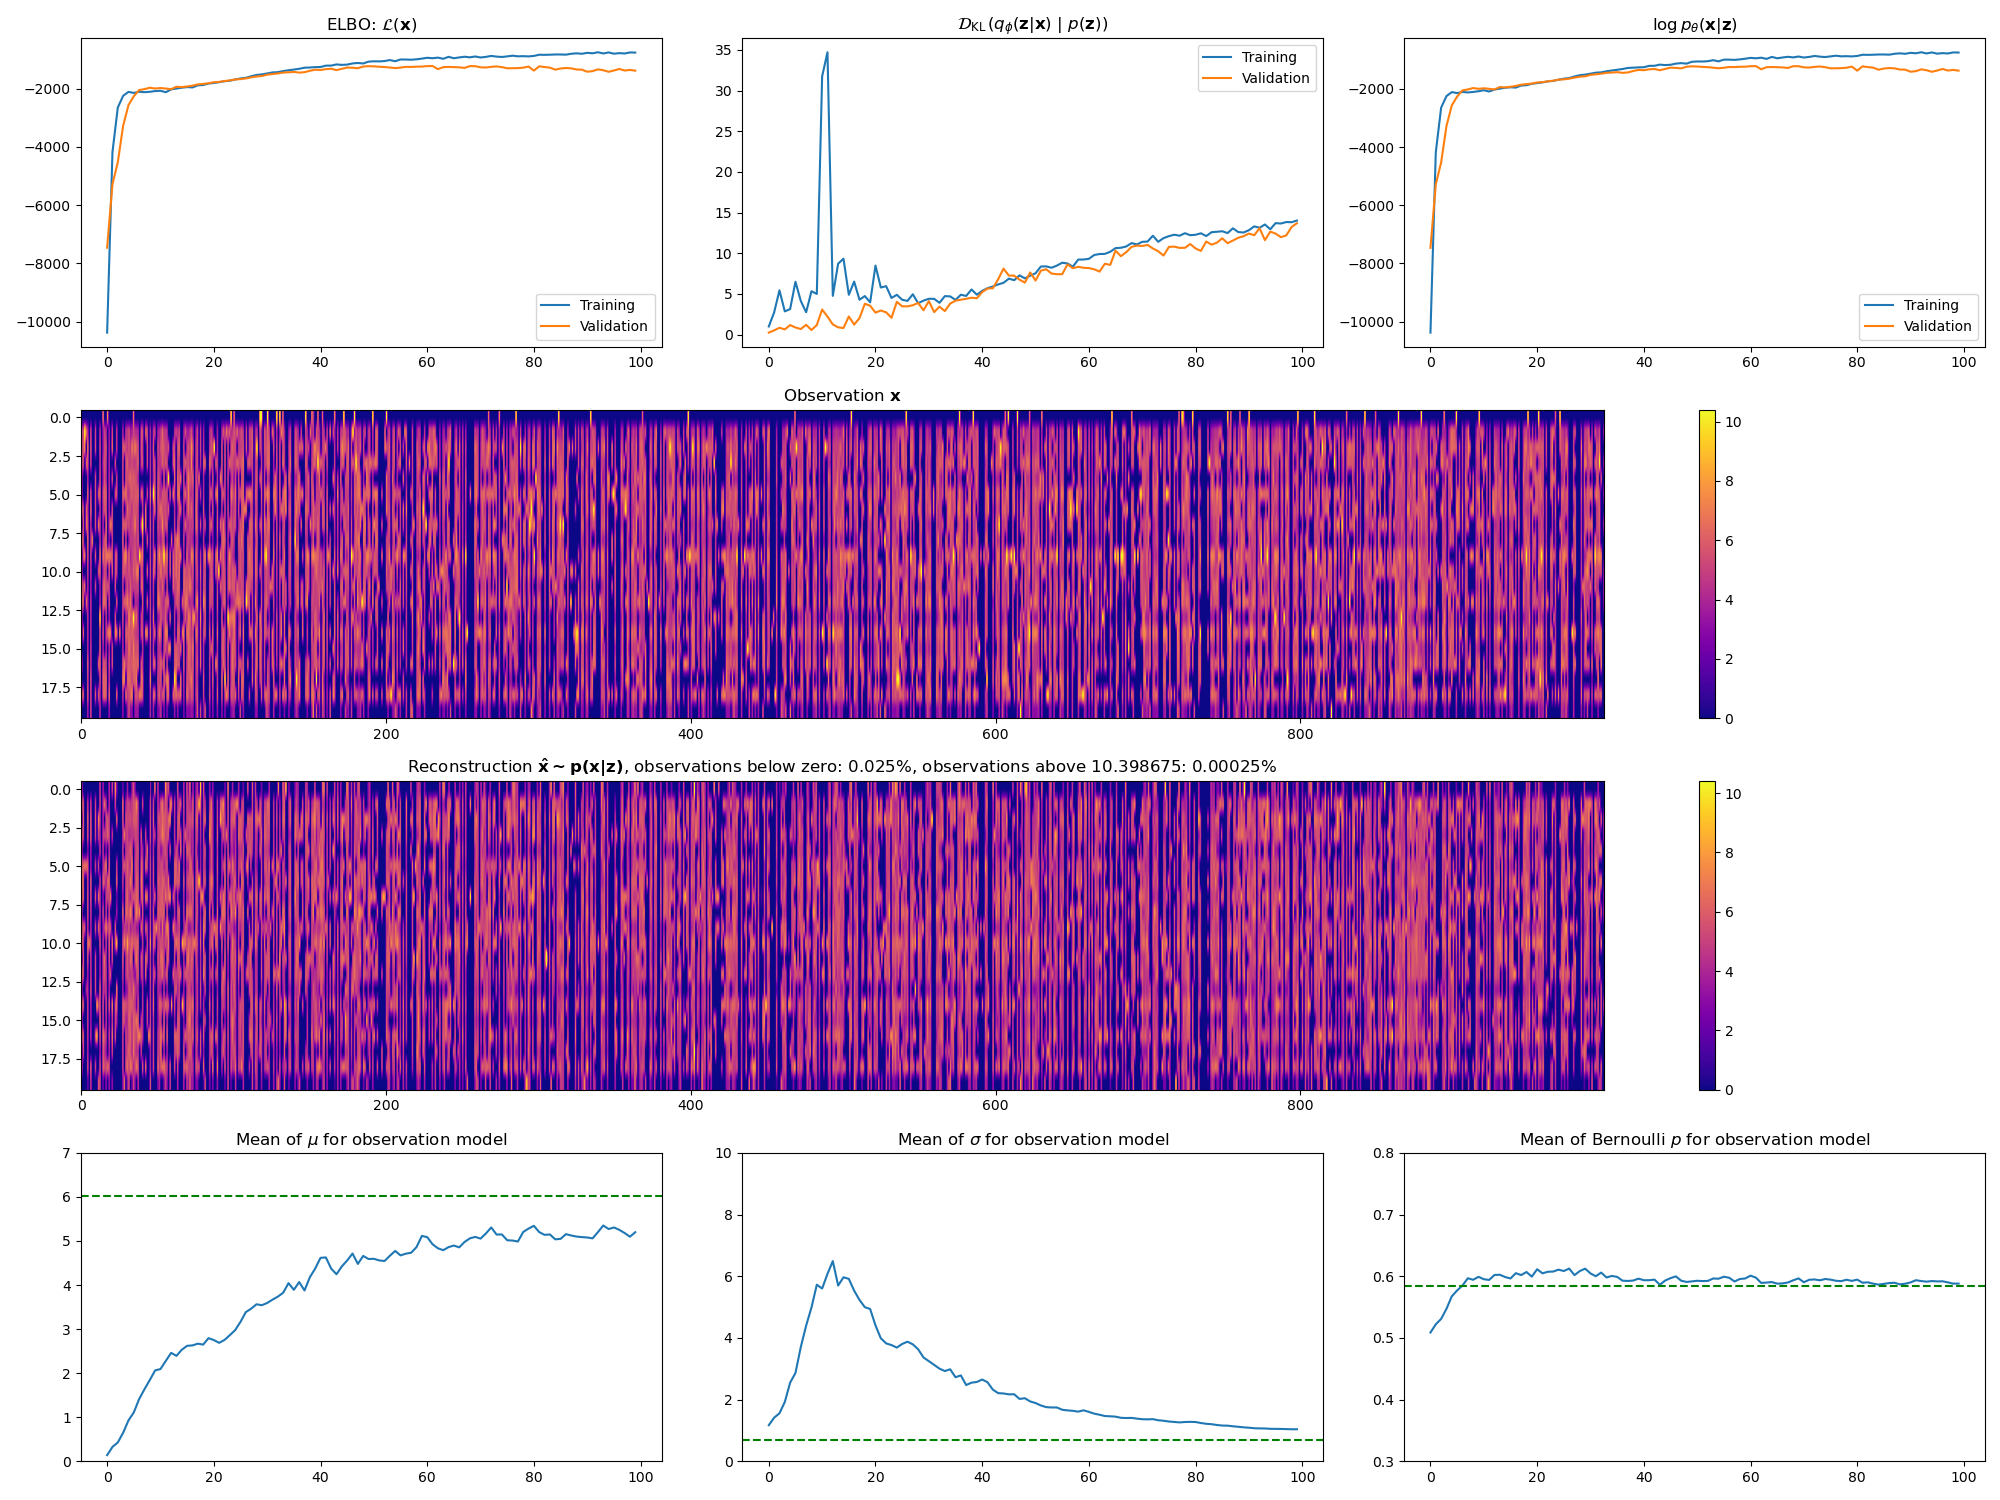

In [9]:
config = {'batch_size': 32, 
          'latent_features':4, 
          'encoder_layer_sizes': [256, 256, 256], 
          'decoder_layer_sizes': [512, 512], 
          'lr': 1e-3,
          'weight_decay': 1e-3}

x_plot, x_hat_plot, cosine, training_data, validation_data = train_and_test(config)

### Cosine similarity between input and reconstruction

In [10]:
cos = torch.nn.CosineSimilarity()
print(f"Last batch mean cosine similarity: {cos(x_plot, x_hat_plot).mean()}")

Last batch mean cosine similarity: 0.7958041429519653


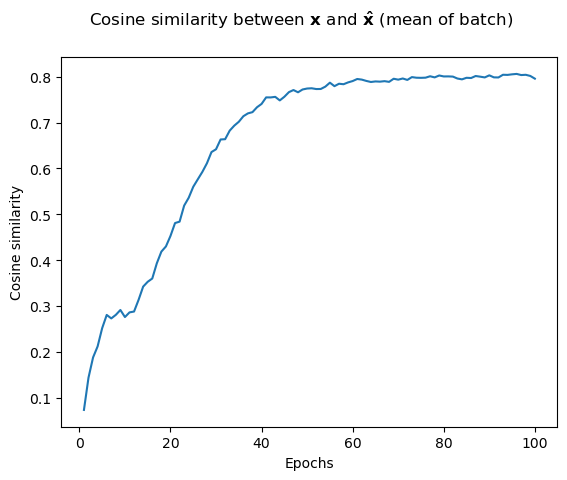

In [11]:
fig, ax = plt.subplots()

ax.plot(np.arange(len(cosine))+1, cosine)
ax.set_xlabel('Epochs')
ax.set_ylabel('Cosine similarity')
fig.suptitle(r"Cosine similarity between $\mathbf{x}$ and $\mathbf{\hat x}$ (mean of batch)")
plt.show()

### Final losses

In [12]:
print(f"Final training elbo (loss):\t {training_data['elbo'][-1]}")
print(f"Final test elbo (loss):\t {validation_data['elbo'][-1]}")

Final training elbo (loss):	 -764.7475179036459
Final test elbo (loss):	 -1385.2559814453125
